# COMS 4995 Applied Machine Learning Project

In [2]:
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, TargetEncoder
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve,classification_report,ConfusionMatrixDisplay

from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import pandas as pd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Cleaning

### At this point, we only focused on the non-textual parts of the dataset, leaving the textual fields for later analysis.

### Summary For Data Cleaning
#### Data Cleaning
- **Missing Values**: Filled text columns with empty strings and categorical columns with "Unknown".
- **Salary Range**: Split `salary_range` into `salary_lower`, `salary_upper`, and calculated `salary_variance`.
- **Location**: Split `location` into `country`, `state`, and `city` for better geographical analysis.

#### Encoding Strategy
- **One-Hot Encoding**: Applied to low-cardinality unordered features (`employment_type`).
- **Target Encoding**: Used for high-cardinality unordered features (`country`, `state`, `city`, `industry`, `function`, `department`).
- **Ordinal Encoding**: Used for ordered features (`required_experience`, `required_education`).
- **Standard Scaling**: Applied to numerical salary-related features (`salary_lower`, `salary_upper`, `salary_variance`).

#### Pipeline with Sampling
- **Integrated Encoding and Sampling**: We should integrate target encoding into the pipeline to ensure it adapts to resampling changes. And it can be accomplished by using a pipeline.

In [3]:
data = pd.read_csv('fake_job_postings.csv')
data.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [4]:
missing_values = data.isnull().sum()
missing_values

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

* For `location`, `department`, `company_profile`, `description`, `requirements`, `benefits`, these columns are text-based and can be handled by filling missing values with an empty string ('') since they can vary widely.
* For `employment_type`, `required_experience`, `required_education`, `industry`, `function`, these columns represent labels or categories. We should fill missing values with "Unknown" to signify an unspecified category.
* For `salary_range`, which we’ll split into salary_lower and salary_upper columns, with missing values set to NaN.

In [5]:
categorical_cols = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']
textual_cols = ['location', 'department', 'company_profile', 'description', 'requirements', 'benefits']
salary_col = 'salary_range' 

In [6]:
data[categorical_cols] = data[categorical_cols].fillna('Unknown')
data[textual_cols] = data[textual_cols].fillna('')

* Here first create a column indicating if the salary range is valid and by a function called has_valid_salary
* THen we define the function parse_salary_range to handle parsing, like transforming 10000-20000 to two variables which one is salary_lower and the other one being salary_upper, it would be 10000 and 20000 respectively.

In [7]:
def has_valid_salary(salary):
    if pd.isnull(salary) or salary == 'Unknown' or salary.strip() == '':
        return 0
    bounds = salary.split('-')
    if len(bounds) == 2 and bounds[0].strip().isdigit() and bounds[1].strip().isdigit():
        return 1
    elif len(bounds) == 1 and bounds[0].strip().isdigit():
        return 1
    return 0

data['has_valid_salary_range'] = data['salary_range'].apply(has_valid_salary)

In [8]:
def parse_salary_range(salary):
    if pd.isnull(salary) or salary == 'Unknown' or salary.strip() == '':
        return np.nan, np.nan
    bounds = salary.split('-')
    try:
        if len(bounds) == 2:
            lower = int(bounds[0].strip())
            upper = int(bounds[1].strip())
        elif len(bounds) == 1:
            lower = upper = int(bounds[0].strip())
        else:
            return np.nan, np.nan
    except ValueError:
        return np.nan, np.nan
    return lower, upper

* Here we apply the parsing function conditionally and assign to new columns
* Then we convert the result to a DataFrame and assign it to `salary_lower` and `salary_upper`

In [9]:
parsed_salaries = data['salary_range'].apply(
    lambda x: parse_salary_range(x) if has_valid_salary(x) else (np.nan, np.nan))

In [10]:
parsed_salary_df = pd.DataFrame(parsed_salaries.tolist(), columns=['salary_lower', 'salary_upper'])
data[['salary_lower', 'salary_upper']] = parsed_salary_df

* Here we display examples where salary_range is not null

In [11]:
df_non_null_salary = data[data['salary_range'].notnull()][['salary_range', 'salary_lower', 'salary_upper','has_valid_salary_range']].head(10)
print(df_non_null_salary)

     salary_range  salary_lower  salary_upper  has_valid_salary_range
6     20000-28000       20000.0       28000.0                       1
10  100000-120000      100000.0      120000.0                       1
15  120000-150000      120000.0      150000.0                       1
23  100000-120000      100000.0      120000.0                       1
31    50000-65000       50000.0       65000.0                       1
42    40000-50000       40000.0       50000.0                       1
65          60-80          60.0          80.0                       1
76    65000-70000       65000.0       70000.0                       1
77         75-115          75.0         115.0                       1
79   75000-110000       75000.0      110000.0                       1


In [12]:
print(data.isnull().sum())

job_id                        0
title                         0
location                      0
department                    0
salary_range              15012
company_profile               0
description                   0
requirements                  0
benefits                      0
telecommuting                 0
has_company_logo              0
has_questions                 0
employment_type               0
required_experience           0
required_education            0
industry                      0
function                      0
fraudulent                    0
has_valid_salary_range        0
salary_lower              15038
salary_upper              15038
dtype: int64


Given the significance of the `salary_range` in predicting fraudulent job postings, it’s essential to capture whether a job listing lacks salary information. While we have attempted to parse and handle salary_range, the high volume of missing or improperly formatted values makes it impractical to impute this data accurately with median or mean values. Thus, our approach is:
*  Instead of imputing `salary_lower` and `salary_upper`, we'll keep them as-is, with NaN indicating missing or unparseable salary data.
* We created a binary column, `has_valid_salary_range`, which will be 1 for entries with valid salary data and 0 for entries with a missing or invalid salary_range. We implement this as the fact that there is no salary range information itself can be useful information in predicting for fraud.
* We will create a seperate pre-processor dropping the NAN salary range for using SMOTE

* Here we splited the location column into country, state, and city columns to help us identify patterns specific to certain locations

In [13]:
location_split = data['location'].str.split(',', expand=True)
data['country'] = location_split[0].str.strip()
data['state'] = location_split[1].str.strip().replace('', 'Unknown')
data['city'] = location_split[2].str.strip().replace('', 'Unknown') if location_split.shape[1] > 2 else 'Unknown'
data['city'] = data['city'].str.split('|').str[-1].str.strip()
print(data[['location', 'country', 'state', 'city']].head())

             location country    state        city
0    US, NY, New York      US       NY    New York
1      NZ, , Auckland      NZ  Unknown    Auckland
2       US, IA, Wever      US       IA       Wever
3  US, DC, Washington      US       DC  Washington
4  US, FL, Fort Worth      US       FL  Fort Worth


* Add another column called `salary_variance` to calculate the difference between salary_upper and salary_lower as a feature, where listings with no range (e.g., 50000-50000) might differ in legitimacy from those with broader ranges.


In [14]:
data['salary_variance'] = data['salary_upper'] - data['salary_lower']

In [15]:
data = data.drop('salary_range', axis=1)

Now applying all these cleaning and encoding techniques as part of our preprocess step

In [16]:
one_hot_features = ['employment_type',"has_valid_salary_range"]           # Low-cardinality, unordered features
target_encoding_features = ['state', 'city', 'country','industry', 'function', 'department']  # High-cardinality, unordered features
ordinal_features = ['required_experience', 'required_education']  # Ordered features with natural rank
num_features = ['salary_lower', 'salary_upper', 'salary_variance']  # Numerical features for scaling

preprocess = make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown="ignore"), one_hot_features),
    (TargetEncoder(), target_encoding_features),
    (OrdinalEncoder(), ordinal_features),
    (StandardScaler(), num_features),
    remainder='drop')

preprocess_smote = make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown="ignore"), one_hot_features),
    (TargetEncoder(), target_encoding_features),
    (OrdinalEncoder(), ordinal_features),
    remainder='drop')


### Sampling

For sampling, we want to see cross compare different sampling strategies, given the dataset is heavily inbalanced, as shown in the graph below

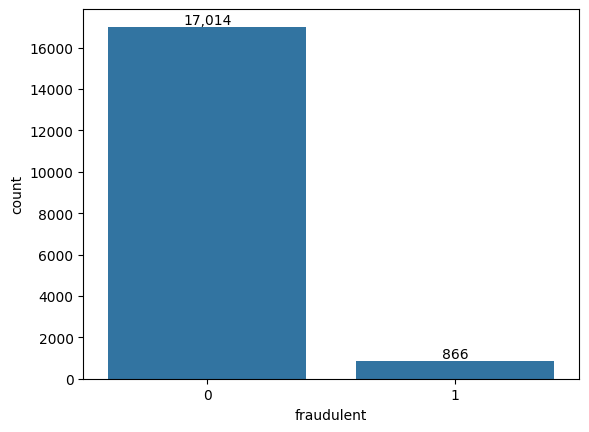

In [17]:
def show_counts(ax):
    for p in ax.patches:
        ax.annotate(format(int(p.get_height()), ','),
                   (p.get_x() + p.get_width()/2., p.get_height()),
                   ha='center',
                   va='center',  # Change to 'bottom' to place above bars
                   xytext=(0, 5),  # 5 points vertical offset
                   textcoords='offset points')

ax = sns.countplot(x='fraudulent', data=data)
show_counts(ax)
plt.show()

In particular, we will compare the performance between four imbalance pipelines related to the four different sampling strateiges: `oversampling_pipe`, `undersampling_pipe`, `smote_pipe`, and `balanced_tree_pipe`, which is only applicable for decision tree based models.

Now, we will split the data and create these four pipelines. We will lean on RandomForest Classifier as the main classifier - thus here we will be experimenting and selecting based on the results of the sampling techniques using Randomforest as a classifier.

Given this is a fraud detection task, we will lean on recall as the key performing metric. Although, depending on the post-fraud-detection process of the website, a low precision score might be disruptive too; for example, we do not have 20% of the job posting to get taken down. Therefore, we will also look at F1 to make a balanced decision on which sampling technique to use.

In [18]:
y = data['fraudulent']
X = data.drop('fraudulent', axis=1)
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=data['fraudulent'])

In [19]:
balanced_tree = RandomForestClassifier(max_depth=10, random_state=42, class_weight='balanced')
regualar_tree = RandomForestClassifier(max_depth=10, random_state=42)

oversampling_pipe = imb_make_pipeline(
    preprocess,
    RandomOverSampler(random_state=42),
    regualar_tree
)
undersampling_pipe = imb_make_pipeline(
    preprocess,
    RandomUnderSampler(random_state=42),
    regualar_tree
)
smote_pipe = imb_make_pipeline(
    preprocess_smote,
    SMOTE(random_state=42),
    regualar_tree
)
balanced_tree_pipe = imb_make_pipeline(
    preprocess,
    balanced_tree
)

Now - we will see the performance of each of the strategies on both validation and test data

In [20]:
test_scores = {}
techniques = ["Balanced Tree", "Oversampling", "Undersampling", "SMOTE"]
for name, pipeline in zip(techniques, [balanced_tree_pipe, oversampling_pipe, undersampling_pipe, smote_pipe]):
    pipeline.fit(X_dev, y_dev)
    y_pred = pipeline.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    recall = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    precision = cm[1, 1] / (cm[0, 1] + cm[1, 1])
    test_scores[name] = {"recall": recall, "precision": precision, "f1": 2 * (precision * recall) / (precision + recall), "test_roc_auc": roc_auc_score(y_test, y_pred)}
pd.DataFrame(test_scores)

,Balanced Tree,Oversampling,Undersampling,SMOTE
recall,0.763006,0.757225,0.843931,0.832370
precision,0.364641,0.313397,0.266423,0.202817
f1,0.493458,0.443316,0.404993,0.326161
test_roc_auc,0.847709,0.836444,0.862900,0.833023


It seems like undersamplng is the most robust technique providing the higest recall and roc_auc, without taking textual data into consideration

## Model Fitting

Now - we will fit a model using RandomForestClassifer and Undersampling technique, and hyper-parameter tune for the best model. We will select `max_depth`, `n_estimators`


In [21]:
max_depths = range(5, 15) 
n_estimators = range(10, 100, 10)

best_params = {}
results = []

for i, depth in enumerate(max_depths):
    for i, n in enumerate(n_estimators):
    
        pipe = imb_make_pipeline(preprocess, 
                                 RandomUnderSampler(random_state=42),
                                 RandomForestClassifier(criterion='entropy', max_depth=depth, n_estimators = n ,random_state=0))
        pipe.fit(X_dev, y_dev)
        y_pred = pipe.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        _recall = cm[1, 1] / (cm[1, 0] + cm[1, 1])
        _precision = cm[1, 1] / (cm[0, 1] + cm[1, 1])
        _f1 = 2 * (_precision * _recall) / (_precision + _recall)
        results.append({
            'max_depth': depth,
            'n_estimators': n,
            'recall': _recall,
            'precision': _precision,
            'f1': _f1
        })
        
best_f1_parameters = pd.DataFrame(results).sort_values('f1', ascending=False).head(1)
best_precision_parameters = pd.DataFrame(results).sort_values('precision', ascending=False).head(1)
best_recall_parameters = pd.DataFrame(results).sort_values('recall', ascending=False).head(1)

print(best_f1_parameters)
print(best_precision_parameters)
print(best_recall_parameters)

    max_depth  n_estimators    recall  precision        f1
66         12            40  0.849711   0.279468  0.420601
    max_depth  n_estimators    recall  precision        f1
66         12            40  0.849711   0.279468  0.420601
    max_depth  n_estimators    recall  precision        f1
79         13            80  0.878613   0.248366  0.387261


Based on the results, we'd lean more on the performance of recall and choose the hyperparameters `max_depth = 13`, `n_estimators = 80`
